# Required Imports

In [27]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from collections import defaultdict

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Dropout, Dense, GlobalAveragePooling2D
from collections import defaultdict
from PIL import ImageFont
import visualkeras

# Document Paths and Model Variables

In [28]:
# === Configuration ===
DATA_DIR = Path("DATASET")
TRAIN_DIR = DATA_DIR / "Train"
TEST_DIR = DATA_DIR / "Test"
LABELS_FILE = DATA_DIR / "label_train.csv"
SUBMISSION_FILE = Path("sub.csv")

RANDOM_STATE = 42
TEST_SIZE = 0.2
BATCH_SIZE = 8
EPOCHS = 120
LEARNING_RATE = 1e-4
IMG_SHAPE = (72, 48, 1)

# Augmantation

In [29]:
# Augmentation function
def rf_augmentace(image: np.ndarray) -> np.ndarray:
    """Random shift, amplitude scaling and Gaussian noise augmentation."""
    image = keras.preprocessing.image.random_shift(
        image, wrg=0.02, hrg=0.02,
        row_axis=0, col_axis=1, channel_axis=2,
        fill_mode='nearest'
    )
    image *= np.random.uniform(0.98, 1.02)
    image += np.random.normal(0.0, 0.01, size=image.shape)
    return image

# Load training labels
train_labels = pd.read_csv(LABELS_FILE)

# Data loading
def load_data(data_dir: Path, labels: pd.DataFrame):
    spectra, targets = [], []
    for _, row in labels.iterrows():
        path = data_dir / f"{row['ID']}.npy"
        spectra.append(np.load(path))
        targets.append(row['target'])
    return np.array(spectra), np.array(targets)

# Data preprocesing

In [30]:
# Preprocessing
def preprocess_data(data: np.ndarray) -> np.ndarray:
    return (data - data.mean()) / data.std()

# Load and preprocess training data
data_raw, labels_raw = load_data(TRAIN_DIR, train_labels)
data_norm = preprocess_data(data_raw)

# Split dataset
X_train, X_val, y_train, y_val = train_test_split(
    data_norm, labels_raw,
    test_size=TEST_SIZE, random_state=RANDOM_STATE,
    stratify=labels_raw
)

# Add channel dimension
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]

# Class weights
dirs = np.unique(y_train)
class_weights = compute_class_weight(
    'balanced', classes=dirs, y=y_train
)
class_weight_dict = dict(zip(dirs, class_weights))

# Sample visualization

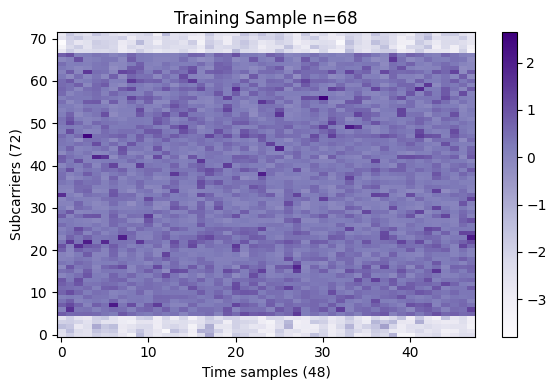

In [31]:
# Sample visualization
def plot_sample(data: np.ndarray, index: int):
    img = data[index]
    arr = img.squeeze() if (img.ndim == 3 and img.shape[-1] == 1) else img
    plt.figure(figsize=(6, 4))
    plt.imshow(arr, cmap='Purples', aspect='auto', interpolation='nearest', origin='lower')
    plt.title(f"Training Sample n={index}")
    plt.xlabel("Time samples (48)")
    plt.ylabel("Subcarriers (72)")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

plot_sample(X_train, index=68)

# Model definition

In [32]:
# Model definition
def build_model(input_shape=IMG_SHAPE, num_classes=None):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.MaxPooling2D(2), layers.BatchNormalization(),
        layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.MaxPooling2D(2), layers.BatchNormalization(),
        layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.MaxPooling2D(2), layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax'),
    ])
    model.compile(
        optimizer=Adam(LEARNING_RATE),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_model(input_shape=IMG_SHAPE, num_classes=len(np.unique(labels_raw)))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 72, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 36, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 36, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 36, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 18, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 18, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 18, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 9, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 9, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,019 (398.51 KB)

 Trainable params: 101,571 (396.76 KB)

 Non-trainable params: 448 (1.75 KB)

# Model diagram

c:\skola\MPC\sem2\MLF\MPA-MLF-Project\.venv\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


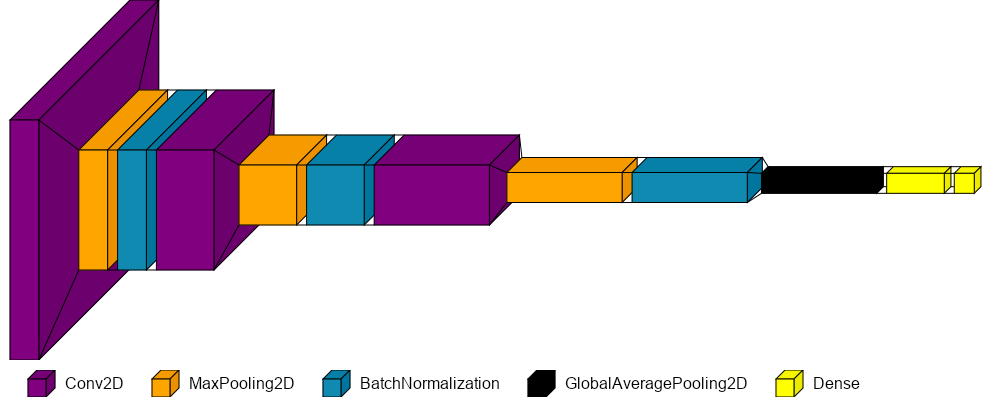

In [33]:
##### Generate model diagram
color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'purple'
color_map[MaxPooling2D]['fill'] = 'orange'
color_map[Dropout]['fill'] = 'green'
color_map[Dense]['fill'] = 'yellow'
color_map[GlobalAveragePooling2D]['fill'] = 'black'
font_type = ImageFont.truetype("arial.ttf", 16)
visualkeras.layered_view(model, legend=True, font=font_type, to_file='diagram.png', spacing=10, scale_xy=5, scale_z=0.9, color_map=color_map)

# Model training

In [34]:
# Model training
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
    ]
)

Epoch 1/120
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7481 - loss: 0.8558 - val_accuracy: 0.8997 - val_loss: 0.7941 - learning_rate: 1.0000e-04
Epoch 2/120
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8733 - loss: 0.4181 - val_accuracy: 0.1037 - val_loss: 1.5027 - learning_rate: 1.0000e-04
Epoch 3/120
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9141 - loss: 0.3075 - val_accuracy: 0.4649 - val_loss: 1.0834 - learning_rate: 1.0000e-04
Epoch 4/120
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9282 - loss: 0.2301 - val_accuracy: 0.9632 - val_loss: 0.2176 - learning_rate: 1.0000e-04
Epoch 5/120
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9137 - loss: 0.2585 - val_accuracy: 0.9833 - val_loss: 0.1307 - learning_rate: 1.0000e-04
Epoch 6/120
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9566 - loss: 0.1810 - val_accuracy: 0.9967 - val_loss: 0.0416 - learning_rate: 1.0000e-04
Epoch 7/120
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/ste

# Figures

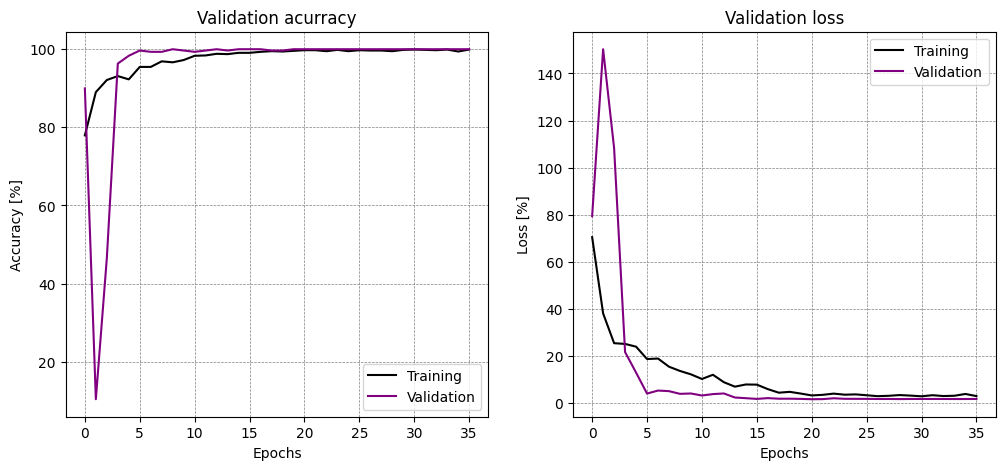

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


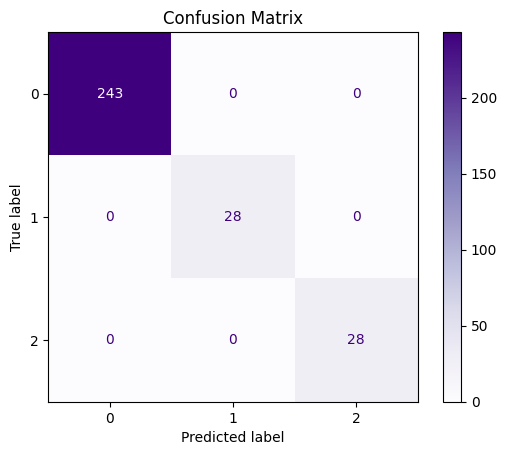

In [38]:

# Plot history
def plot_history(history):
    plt.figure(figsize=(12,5))
    # plot Acc    
    plt.subplot(1,2,1)
    plt.plot([x * 100 for x in history.history['accuracy']], color='black', label='Training')
    plt.plot([x * 100 for x in history.history['val_accuracy']], color='purple', label='Validation')
    plt.title('Validation acurracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy [%]')
    plt.legend()
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
   


    # plot Loss
    plt.subplot(1,2,2)
    plt.plot([x * 100 for x in history.history['loss']], color='black', label='Training')
    plt.plot([x * 100 for x in history.history['val_loss']], color='purple', label='Validation')
    plt.title('Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss [%]')
    plt.legend()
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    plt.show()


    # Confusion matrix
    preds = np.argmax(model.predict(X_val), axis=1)
    cm = confusion_matrix(y_val, preds)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap='Purples')
    plt.title('Confusion Matrix')
    plt.show()

plot_history(history)

# Save data for Kaggle

In [36]:
# Load and predict test data
def load_and_preprocess_test(test_dir: Path):
    files = sorted(test_dir.iterdir(), key=lambda p: int(p.stem))
    arrays = [np.load(f) for f in files]
    stack = np.stack(arrays, axis=0)
    norm = (stack - stack.mean()) / stack.std()
    return norm[..., np.newaxis], [f.stem for f in files]

X_test, test_ids = load_and_preprocess_test(TEST_DIR)
preds = np.argmax(model.predict(X_test), axis=1)
pd.DataFrame({'ID': test_ids, 'target': preds}).to_csv(SUBMISSION_FILE, index=False)
print(f"Saved predictions to {SUBMISSION_FILE}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Saved predictions to sub.csv
